In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = "../data/reliance_weekly_data.csv"
df = pd.read_csv(filename)
df.head()

,Symbol,High,Low,Open Price,Close Price,Average Trading Price,52 Week Low,52 Week High
0,RELIANCE,2537.7,2326.00,2377.00,2498.15,2442.45,2180.0,2856.15
1,RELIANCE,2755.0,2492.25,2606.75,2536.90,2619.26,2180.0,2856.15
2,RELIANCE,2755.0,2434.60,2589.00,2467.60,2604.60,2180.0,2856.15
3,RELIANCE,2748.0,2427.00,2730.00,2442.65,2556.57,2180.0,2856.15
4,RELIANCE,2660.0,2311.65,2646.00,2337.35,2508.80,2180.0,2856.15


### Define all the technical Indicators here if not using built in function 

In [3]:
def simple_moving_average(data:pd.DataFrame, ndays:int): 
    """
    Function to find the Simple Moving Average. Since this data is weekly, this variable can be updated on a weekly basis, i.e. 
    the data of each week is used to compute the average
    """
    SMA = pd.Series(data['Close Price'].rolling(ndays).mean(), name = 'SMA') 
    data = data.join(SMA) 
    return data

def expo_weighted_moving_average(data, ndays): 
    """
    Function to find the Simple Moving Average. Since this data is weekly, this variable can be updated on a weekly basis, i.e. 
    the data of each week is used to compute the average
    """
    EMA = pd.Series(data['Close Price'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA' + str(ndays)) 
    data = data.join(EMA) 
    return data

def bollinger_bands(data, window):
    """
    Function to create bollinger bands, the gap between these bands determines the volatility of that stock  
    """
    MA = data['Close Price'].rolling(window).mean()
    SD = data['Close Price'].rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

def relative_strength_index(close, periods = 2):
    """
    Function to create the Relative Strength Index
    """
        
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi


def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


def mfi(high, low, close, volume, n=2):
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()



In [4]:
n = 5
sma = simple_moving_average(df,n)
df = sma

n = 5
ewma = expo_weighted_moving_average(df,n)
df = ewma

n = 5
bb = bollinger_bands(df,n)
df = bb

df['RSI'] = relative_strength_index(df['Close Price'])

df['MFI'] = mfi(df['High'], df['Low'], df['Close Price'], df['Volume'], 14)



df.head() 

,Symbol,High,Low,Open Price,Close Price,Average Trading Price,52 Week Low,52 Week High,SMA,EWMA5,MiddleBand,UpperBand,LowerBand,RSI
0,RELIANCE,2537.7,2326.00,2377.00,2498.15,2442.45,2180.0,2856.15,NaN,NaN,NaN,NaN,NaN,NaN
1,RELIANCE,2755.0,2492.25,2606.75,2536.90,2619.26,2180.0,2856.15,NaN,NaN,NaN,NaN,NaN,NaN
2,RELIANCE,2755.0,2434.60,2589.00,2467.60,2604.60,2180.0,2856.15,NaN,NaN,NaN,NaN,NaN,21.849450
3,RELIANCE,2748.0,2427.00,2730.00,2442.65,2556.57,2180.0,2856.15,NaN,2473.790000,NaN,NaN,NaN,13.981598
4,RELIANCE,2660.0,2311.65,2646.00,2337.35,2508.80,2180.0,2856.15,2456.53,2421.412559,2456.53,2607.230474,2305.829526,3.461212


### Visualising these technical Indicators

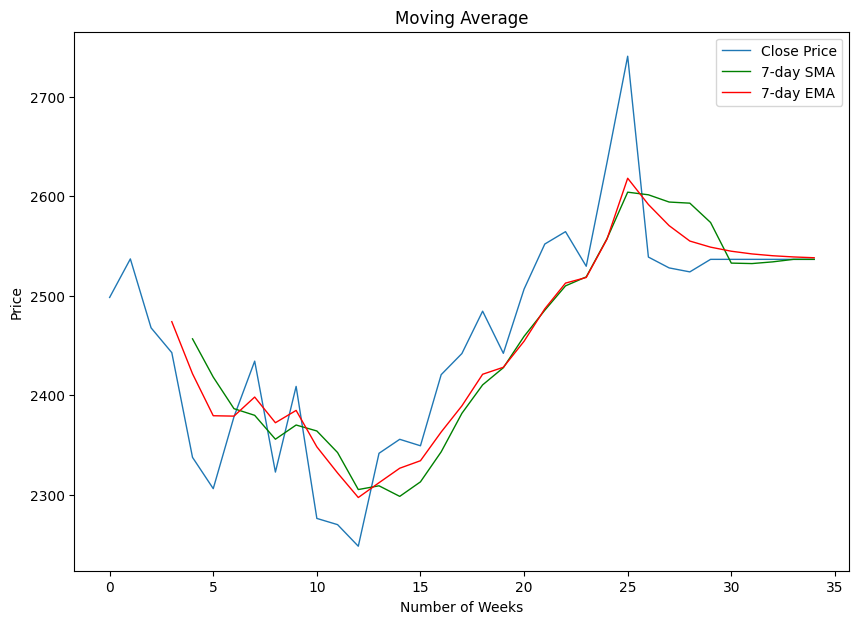

In [5]:
plt.figure(figsize=(10,7))

# Set the title and axis labels
plt.title('Moving Average')
plt.xlabel('Number of Weeks')
plt.ylabel('Price')

# Plot close price and moving averages
plt.plot(df['Close Price'],lw=1, label='Close Price')
plt.plot(df['SMA'],'g',lw=1, label='7-day SMA')
plt.plot(df['EWMA5'],'r', lw=1, label='7-day EMA')

# Add a legend to the axis
plt.legend()

plt.show()

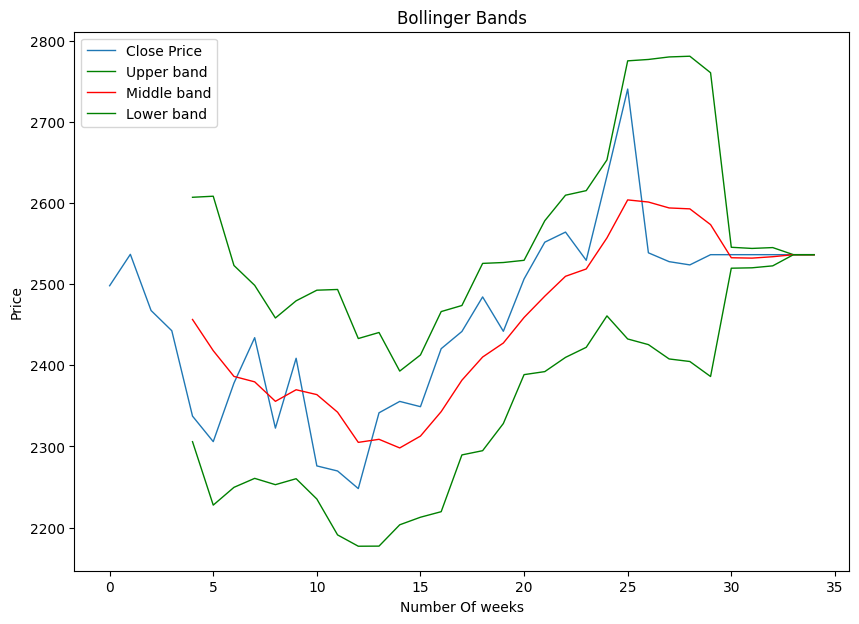

In [7]:
plt.figure(figsize=(10,7))

# Set the title and axis labels
plt.title('Bollinger Bands')
plt.xlabel('Number Of weeks')
plt.ylabel('Price')

plt.plot(df['Close Price'],lw=1, label='Close Price')
plt.plot(df['UpperBand'],'g',lw=1, label='Upper band')
plt.plot(df['MiddleBand'],'r',lw=1, label='Middle band')
plt.plot(df['LowerBand'],'g', lw=1, label='Lower band')

# Add a legend to the axis
plt.legend()

plt.show()

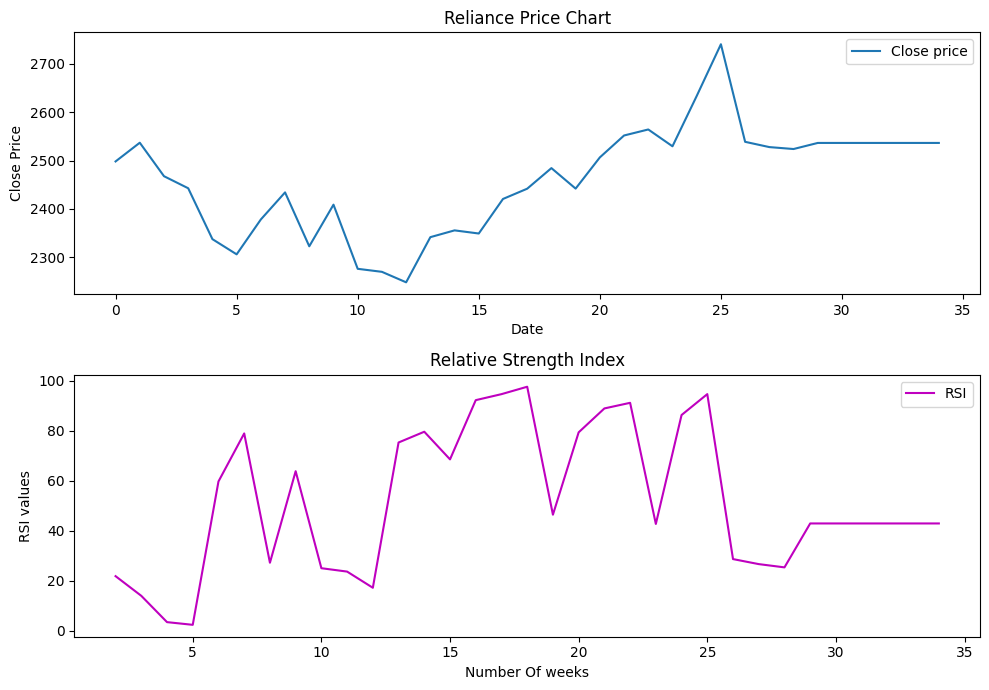

In [8]:
fig = plt.figure(figsize=(10, 7))

# Define position of 1st subplot
ax = fig.add_subplot(2, 1, 1)

# Set the title and axis labels
plt.title('Reliance Price Chart')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.plot(df['Close Price'], label='Close price')

# Add a legend to the axis
plt.legend()

# Define position of 2nd subplot
bx = fig.add_subplot(2, 1, 2)

# Set the title and axis labels
plt.title('Relative Strength Index')
plt.xlabel('Number Of weeks')
plt.ylabel('RSI values')

plt.plot(df['RSI'], 'm', label='RSI')

# Add a legend to the axis
plt.legend()

plt.tight_layout()
plt.show()